# Importing dependencies 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fast')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
df = pd.read_csv('data_science_job.csv')

# Introductory EDA

In [3]:
# Checking the shape of the dataframe
df.shape

(19158, 13)

In [4]:
# Checking any 5 random rows
df.sample(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,training_hours,target
14733,20313,city_103,0.920,Female,No relevent experience,no_enrollment,High School,NaN,0.0,NaN,NaN,48.0,0.0
8383,3217,city_103,0.920,NaN,Has relevent experience,no_enrollment,Graduate,STEM,20.0,500-999,Pvt Ltd,111.0,0.0
18257,31936,city_61,0.913,Male,Has relevent experience,no_enrollment,Masters,STEM,16.0,100-500,Pvt Ltd,80.0,0.0
13841,9392,city_114,0.926,Male,Has relevent experience,no_enrollment,Masters,STEM,17.0,50-99,Pvt Ltd,89.0,0.0
8195,28164,city_11,0.550,Male,Has relevent experience,no_enrollment,Graduate,STEM,8.0,NaN,NaN,11.0,0.0


In [5]:
# Checking data type of the features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  18679 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  float64
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  training_hours          18392 non-null  float64
 12  target                  19158 non-null  float64
dtypes: float64(4), int64(1), object(8)
memory usage: 1.9+ MB


In [6]:
# Optimizing the memory by using appropriate data types
df[['target','training_hours','experience','city_development_index']] = df[['target','training_hours','experience','city_development_index']].astype(np.float32)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  18679 non-null  float32
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  float32
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  training_hours          18392 non-null  float32
 12  target                  19158 non-null  float32
dtypes: float32(4), int64(1), object(8)
memory usage: 1.6+ MB


In [7]:
# Descriptive information about the data
df.describe()

,enrollee_id,city_development_index,experience,training_hours,target
count,19158.000000,18679.000000,19093.000000,18392.000000,19158.000000
mean,16875.358179,0.828951,9.928037,65.185791,0.249348
std,9616.292592,0.123334,6.505268,59.885624,0.432647
min,1.000000,0.448000,0.000000,1.000000,0.000000
25%,8554.250000,0.740000,4.000000,23.000000,0.000000
50%,16982.500000,0.903000,9.000000,47.000000,0.000000
75%,25169.750000,0.920000,16.000000,88.000000,0.000000
max,33380.000000,0.949000,20.000000,336.000000,1.000000


In [8]:
# Checking percentage of null values
df.isnull().mean()*100

enrollee_id                0.000000
city                       0.000000
city_development_index     2.500261
gender                    23.530640
relevent_experience        0.000000
enrolled_university        2.014824
education_level            2.401086
major_discipline          14.683161
experience                 0.339284
company_size              30.994885
company_type              32.049274
training_hours             3.998330
target                     0.000000
dtype: float64

In [9]:
# Checking duplicated values
df.duplicated().sum()

0

<AxesSubplot:ylabel='target'>

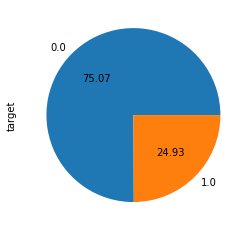

In [10]:
# Let's visualize distribution of the classes in the target variable
df['target'].value_counts().plot(kind='pie',autopct='%.2f')

# Data preprocessing

In this step we will be handling the missing values,outliers and will also work on dealing with imbalanced data


In [11]:
# Dropping the unnecessary columns from the dataframe
df = df.drop(['enrollee_id','city'],axis=1)
df.head(4)

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,training_hours,target
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,20.0,NaN,NaN,36.0,1.0
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,47.0,0.0
2,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5.0,NaN,NaN,83.0,0.0
3,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,0.0,NaN,Pvt Ltd,52.0,1.0


In [12]:
# Let's take out features having missing value percentage less than 5% to check if we should apply CCA or not
check_cca = [col for col in df.columns if df[col].isnull().mean()*100 <5 and df[col].isnull().mean()*100>0]
check = df[check_cca].copy()
check.head(5)

,city_development_index,enrolled_university,education_level,experience,training_hours
0,0.920,no_enrollment,Graduate,20.0,36.0
1,0.776,no_enrollment,Graduate,15.0,47.0
2,0.624,Full time course,Graduate,5.0,83.0
3,0.789,NaN,Graduate,0.0,52.0
4,0.767,no_enrollment,Masters,20.0,8.0


In [13]:
# Dropping all the rows having column values as NaN
check.dropna(inplace=True)

<AxesSubplot:>

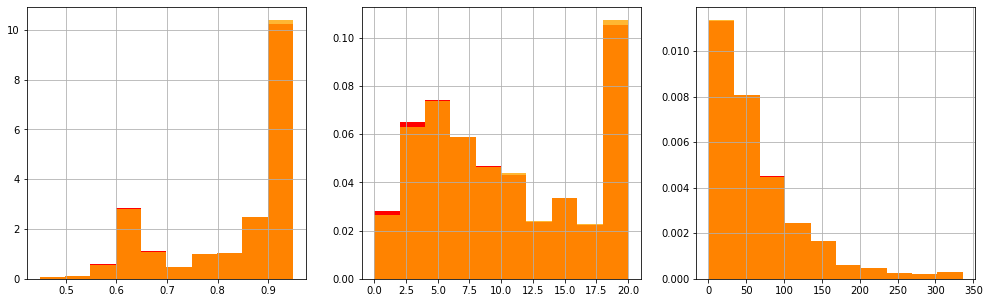

In [14]:
# Now let's visualize the distributions before and after implemnting CCA on numerical features
fig, ax = plt.subplots(1, 3, figsize=(17, 5))

df['city_development_index'].hist(ax=ax[0], density=True, color='red')
check['city_development_index'].hist(ax=ax[0], color='orange', density=True, alpha=0.8)

df['experience'].hist(ax=ax[1], density=True, color='red')
check['experience'].hist(ax=ax[1], color='orange', density=True, alpha=0.8)

df['training_hours'].hist(ax=ax[2], density=True, color='red')
check['training_hours'].hist(ax=ax[2], color='orange', density=True, alpha=0.8)

For the categorical columns we will check the ratio of categories before and after applying PCA

In [15]:
# For the categorical features we will check the ratio of classes before and after implementing CCA
compare_eu = pd.concat([df['enrolled_university'].value_counts() / len(df),
                    check['enrolled_university'].value_counts() / len(check)],axis=1)

compare_eu.columns = ['original','aftercca']
compare_eu

,original,aftercca
no_enrollment,0.721213,0.735188
Full time course,0.196106,0.200733
Part time course,0.062533,0.064079


In [16]:
edu_level = pd.concat([ df['education_level'].value_counts() / len(df),
                     check['education_level'].value_counts() / len(check) ],axis=1)

edu_level.columns = ['original','aftercca']
edu_level

,original,aftercca
Graduate,0.605387,0.619835
Masters,0.227633,0.234082
High School,0.105282,0.107380
Phd,0.021610,0.022116
Primary School,0.016077,0.016587


From the analysis we can safely remove the rows having missing values of columns in which the percentage of missing values is less than 5%

In [17]:
df.dropna(subset = ['city_development_index', 'enrolled_university', 'education_level',
                   'experience', 'training_hours'],inplace=True)

In [18]:
# Let's take all those features in which percentage of missing value is more than 5%
check_cols2 = [cols for cols in df.columns if df[cols].isnull().mean()*100 >5]
check2 = df[check_cols2].copy()
check2.head(4)

,gender,major_discipline,company_size,company_type
0,Male,STEM,NaN,NaN
1,Male,STEM,50-99,Pvt Ltd
2,NaN,STEM,NaN,NaN
4,Male,STEM,50-99,Funded Startup


In [19]:
check2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17182 entries, 0 to 19157
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            13309 non-null  object
 1   major_discipline  15029 non-null  object
 2   company_size      12064 non-null  object
 3   company_type      11890 non-null  object
dtypes: object(4)
memory usage: 671.2+ KB


In [20]:
"""
    For encoding these features we will use MICE : Multiple imputation by chanied equation but before we need to encode these 
    features by treating them as ordinal categorical data even though the features are nominal and we need to do this for implmenting
    MICE because with OHE the dataset will become sparse.
"""
map_gender = {'Male':1,'Female':2,'Other':3}
map_disciline = {'STEM':5,'Humanities':4,'Other':3,'Business Degree':2,'Arts':1,'No Major':0}
map_comp_size = {'<10':0,'10/49':1,'50-99':2,'100-500':3,'500-999':4,'1000-4999':5,'5000-9999':6,'10000+':7 }
map_comp_type = {'Other':0,'NGO':1,'Early Stage Startup':2,'Public Sector':3,'Funded Startup':4,'Pvt Ltd':5}

check2['gender'] = check2['gender'].map(map_gender)
check2['major_discipline'] = check2['major_discipline'].map(map_disciline)
check2['company_size'] = check2['company_size'].map(map_comp_size)
check2['company_type'] = check2['company_type'].map(map_comp_type)

In [21]:
# Now we will be using MICE for imputing the missing values in company_size variable
lr = LinearRegression()
imp = IterativeImputer(estimator=lr, verbose=2, max_iter=30, tol=1e-10, imputation_order='roman')

In [22]:
check2 = imp.fit_transform(check2)

[IterativeImputer] Completing matrix with shape (17182, 4)
[IterativeImputer] Ending imputation round 1/30, elapsed time 0.02
[IterativeImputer] Change: 1.2012693158805423, scaled tolerance: 7.000000000000001e-10 
[IterativeImputer] Ending imputation round 2/30, elapsed time 0.05
[IterativeImputer] Change: 0.153632813480566, scaled tolerance: 7.000000000000001e-10 
[IterativeImputer] Ending imputation round 3/30, elapsed time 0.07
[IterativeImputer] Change: 0.02980737756246965, scaled tolerance: 7.000000000000001e-10 
[IterativeImputer] Ending imputation round 4/30, elapsed time 0.09
[IterativeImputer] Change: 0.005767774600682785, scaled tolerance: 7.000000000000001e-10 
[IterativeImputer] Ending imputation round 5/30, elapsed time 0.11
[IterativeImputer] Change: 0.0010324150228893103, scaled tolerance: 7.000000000000001e-10 
[IterativeImputer] Ending imputation round 6/30, elapsed time 0.14
[IterativeImputer] Change: 0.00017544954630110965, scaled tolerance: 7.000000000000001e-10 
[I

In [23]:
check2 = pd.DataFrame(check2,columns = ['gender','major_discipline','company_size','company_type'])
check2 = round(check2)
check2.head(4)

,gender,major_discipline,company_size,company_type
0,1.0,5.0,3.0,4.0
1,1.0,5.0,2.0,5.0
2,1.0,5.0,3.0,4.0
3,1.0,5.0,2.0,4.0


In [24]:
# Now after imputing let's change the values back to category for the analysis
map_gender = {1.0:'Male',2.0:'Female',3.0:'Other'}
map_disciline = {5.0:'STEM',4.0:'Humanities',3.0:'Other',2.0:'Business Degree',1.0:'Arts',0.0:'No Major'}
map_comp_size = {0.0:'<10',1.0:'10/49',2.0:'50-99',3.0:'100-500',4.0:'500-999',5.0:'1000-4999',6.0:'5000-9999',7.0:'10000+' }
map_comp_type = {0.0:'Other',1.0:'NGO',2.0:'Early Stage Startup',3.0:'Public Sector',4.0:'Funded Startup',5.0:'Pvt Ltd'}

check2['gender'] = check2['gender'].map(map_gender)
check2['major_discipline'] = check2['major_discipline'].map(map_disciline)
check2['company_size'] = check2['company_size'].map(map_comp_size)
check2['company_type'] = check2['company_type'].map(map_comp_type)

<AxesSubplot:>

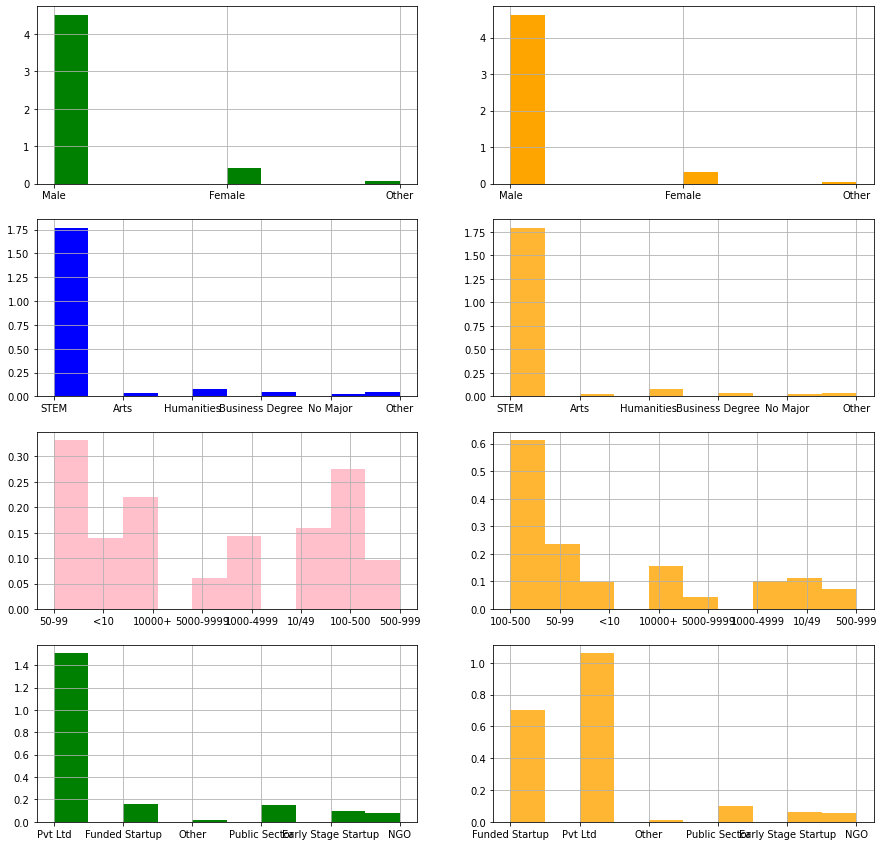

In [25]:
# Let's check the distribution before and after the imputation
fig,ax = plt.subplots(4,2 ,figsize=(15, 15))

df['gender'].hist(ax=ax[0][0], density=True, color='green')
check2['gender'].hist(ax=ax[0][1], color='orange', density=True)

df['major_discipline'].hist(ax=ax[1][0], density=True, color='blue')
check2['major_discipline'].hist(ax=ax[1][1], color='orange', density=True, alpha=0.8)

df['company_size'].hist(ax=ax[2][0], density=True, color='pink')
check2['company_size'].hist(ax=ax[2][1], color='orange', density=True, alpha=0.8)

df['company_type'].hist(ax=ax[3][0], density=True, color='green')
check2['company_type'].hist(ax=ax[3][1], color='orange', density=True, alpha=0.8)

In [26]:
check2.columns = ['Gender','Major_disciline','Company_Size','Company_Type']
df = pd.concat([df,check2],axis=1)
df = df.drop(['gender','major_discipline','company_size','company_type'],axis=1)
df.head(5)

,city_development_index,relevent_experience,enrolled_university,education_level,experience,training_hours,target,Gender,Major_disciline,Company_Size,Company_Type
0,0.920,Has relevent experience,no_enrollment,Graduate,20.0,36.0,1.0,Male,STEM,100-500,Funded Startup
1,0.776,No relevent experience,no_enrollment,Graduate,15.0,47.0,0.0,Male,STEM,50-99,Pvt Ltd
2,0.624,No relevent experience,Full time course,Graduate,5.0,83.0,0.0,Male,STEM,100-500,Funded Startup
4,0.767,Has relevent experience,no_enrollment,Masters,20.0,8.0,0.0,Male,STEM,100-500,Funded Startup
5,0.764,Has relevent experience,Part time course,Graduate,11.0,24.0,1.0,Male,STEM,50-99,Funded Startup


# Detection and removal of outliers

[Text(0.5, 1.0, 'Distribution of city development index feature')]

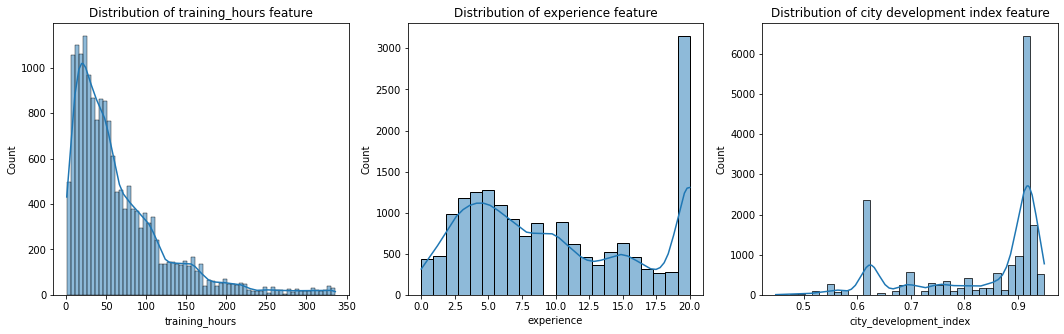

In [47]:
fig,ax = plt.subplots(1,3,figsize = (18,5))

sns.histplot(df['training_hours'],kde=True,ax= ax[0]).set(title='Distribution of training_hours feature')
sns.histplot(df['experience'],kde=True,ax= ax[1]).set(title='Distribution of experience feature')
sns.histplot(df['city_development_index'],kde=True,ax= ax[2]).set(title='Distribution of city development index feature')

From the distributions we can clearly see that all the features are skewed. Training hours and experience are right skewed , whereas city development index distribution is left skewed. So we will use boxplots to detect outliers

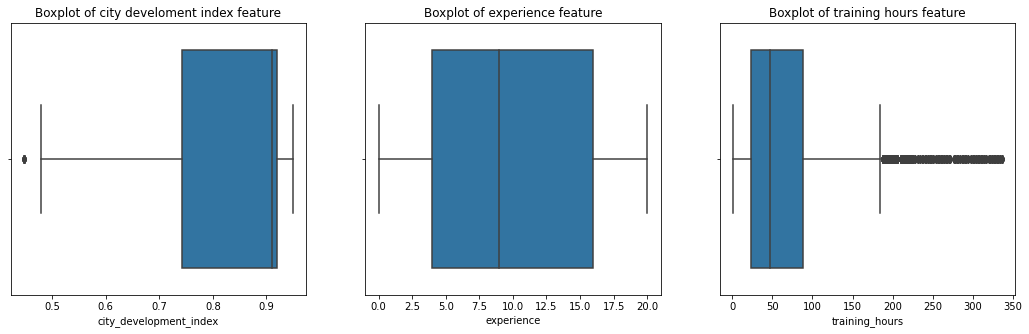

In [53]:
# Create a figure and axes
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot the first distplot on the first axes
sns.boxplot(x = df['city_development_index'],ax = ax[0]).set(title='Boxplot of city develoment index feature')
sns.boxplot(x = df['experience'],ax = ax[1]).set(title='Boxplot of experience feature')
sns.boxplot(x = df['training_hours'],ax = ax[2]).set(title='Boxplot of training hours feature')

# Show the plot
plt.show()

# Data analysis part 2
1. Does individuals with relevent experience gets more job ?
2. Does the individuals with full time enrollment gets more job than part time enrollment or no enrollment at all?
3. Individuals with which education level get most jobs ?
4. Does individuals with STEM backgroun get more jobs?
5. In which company size inidividuals gets more jobs ?
6. Which type of company hires the most ?

[Text(0.5, 1.0, 'Company type Vs Number of jobs')]

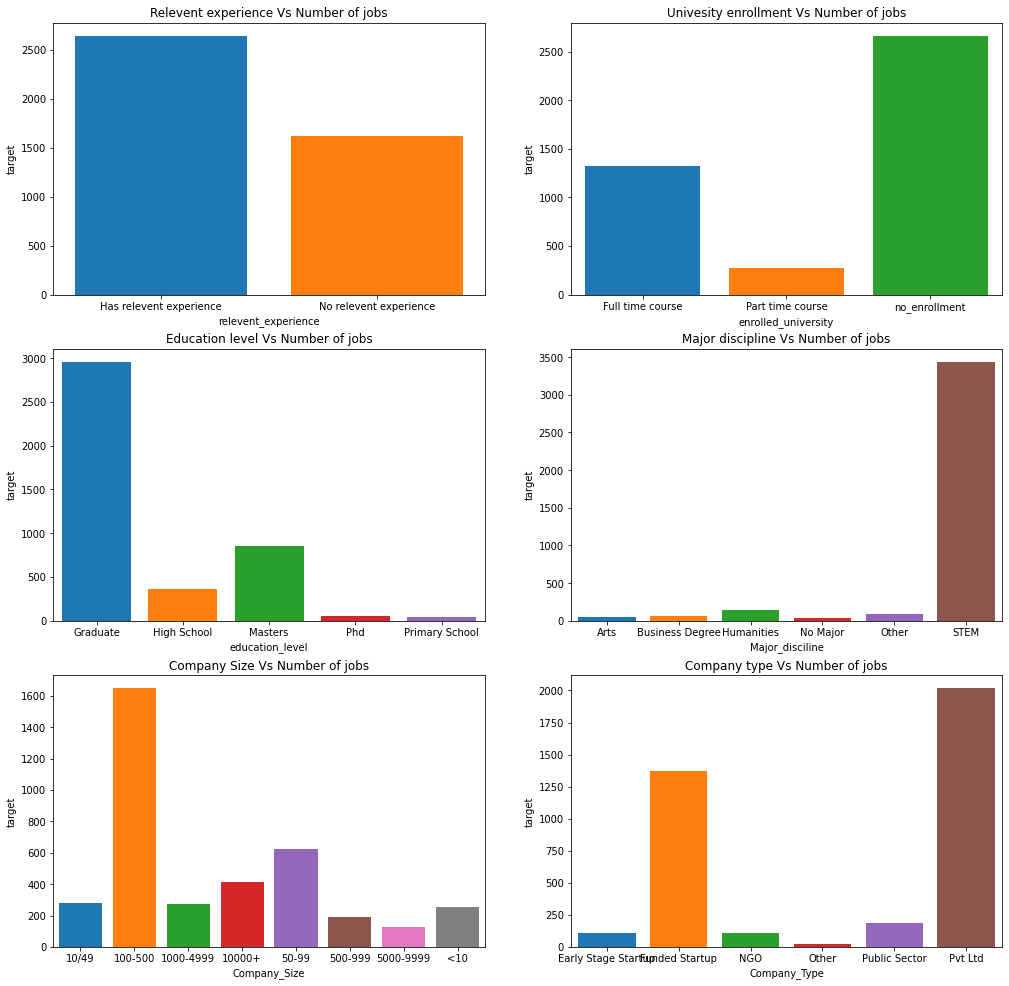

In [34]:
# Let's create subplots
fig,ax = plt.subplots(3,2 ,figsize = (17,17))

temp1 = df.groupby('relevent_experience')['target'].sum()
temp2 = df.groupby('enrolled_university')['target'].sum()
temp3 = df.groupby('education_level')['target'].sum()
temp4 = df.groupby('Major_disciline')['target'].sum()
temp5 = df.groupby('Company_Size')['target'].sum()
temp6 = df.groupby('Company_Type')['target'].sum()

sns.barplot(x = temp1.index,y = temp1,ax = ax[0][0],saturation=2).set(title='Relevent experience Vs Number of jobs')
sns.barplot(x = temp2.index,y = temp2,ax = ax[0][1],saturation=2).set(title='Univesity enrollment Vs Number of jobs')
sns.barplot(x = temp3.index,y = temp3,ax = ax[1][0],saturation=2).set(title='Education level Vs Number of jobs')
sns.barplot(x = temp4.index,y = temp4,ax = ax[1][1],saturation=2).set(title='Major discipline Vs Number of jobs')
sns.barplot(x = temp5.index,y = temp5,ax = ax[2][0],saturation=2).set(title='Company Size Vs Number of jobs')
sns.barplot(x = temp6.index,y = temp6,ax = ax[2][1],saturation=2).set(title='Company type Vs Number of jobs')

In [29]:
# Encoding company size
map_comp_size = {'<10':0,'10/49':1,'50-99':2,'100-500':3,'500-999':4,'1000-4999':5,'5000-9999':6,'10000+':7 }
df['company_size'] = df['company_size'].map(map_comp_size)

In [20]:
# Encoding enrolled_university column 

map_eu = {'Full time course':2 ,'Part time course':1, 'no_enrollment':0}
df['enrolled_university'] = df['enrolled_university'].map(map_eu)

In [21]:
# Encoding education_level column

map_el = {'Primary School':0, 'High School':1, 'Graduate':2,'Masters':3,'Phd':4}
df['education_level'] = df['education_level'].map(map_el)

In [22]:
# Encoding relevant experience column 

map_re = {'Has relevent experience':1,'No relevent experience':0}
df['relevent_experience'] = df['relevent_experience'].map(map_re)

[IterativeImputer] Completing matrix with shape (17182, 7)
[IterativeImputer] Ending imputation round 1/30, elapsed time 0.06
[IterativeImputer] Change: 1.1481516213348897, scaled tolerance: 3.36e-08 
[IterativeImputer] Ending imputation round 2/30, elapsed time 0.11
[IterativeImputer] Change: 0.0, scaled tolerance: 3.36e-08 
[IterativeImputer] Early stopping criterion reached.


In [25]:
new_df = pd.DataFrame(X)
new_df.columns = ['city_development_index', 'relevent_experience', 'enrolled_university',
       'education_level', 'experience', 'company_size', 'training_hours']

In [26]:
target = df['target'].values
target = pd.Series(target)
new_df['Output'] = target

In [27]:
new_df.head(5)

,city_development_index,relevent_experience,enrolled_university,education_level,experience,company_size,training_hours,Output
0,0.920,1.0,0.0,2.0,20.0,3.537382,36.0,1.0
1,0.776,0.0,0.0,2.0,15.0,2.000000,47.0,0.0
2,0.624,0.0,2.0,2.0,5.0,3.097107,83.0,0.0
3,0.767,1.0,0.0,3.0,20.0,2.000000,8.0,0.0
4,0.764,1.0,1.0,2.0,11.0,3.093206,24.0,1.0


In [28]:
check = new_df['company_size'].astype(np.int32)
check

0        3
1        2
2        3
3        2
4        3
        ..
17177    3
17178    3
17179    2
17180    4
17181    2
Name: company_size, Length: 17182, dtype: int32

### Detecting outliers

- Left skewed : city_dev_index
- Right skewed : experience , training_hours
- Normal distribution

*Unfortunately, there are no outlier detection methods for categorical data [1]. However, you can use measures such as the mode to get an understanding of the distribution of the data. Additionally, you can use tools such as box and whisker plots to visualize the distribution of the data and identify any potential outliers.*


*If a boxplot is showing an IQR (interquartile range) that is the same length as the entire plot, it means that there is no variation in the data. This could be due to all the data points having the same value, or due to the data being heavily skewed in one direction. If you're seeing this, it could be worth investigating further to see what is causing the lack of variation.*

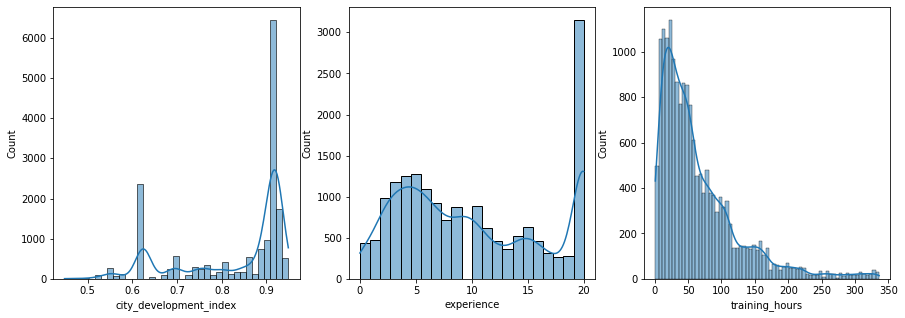

In [29]:
# Create a figure and axes
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first distplot on the first axes
sns.histplot(new_df['city_development_index'],kde=True, ax=ax[0])
sns.histplot(new_df['experience'],kde=True, ax=ax[1])
sns.histplot(new_df['training_hours'],kde=True, ax=ax[2])

# Show the plot
plt.show()

Since all the above 3 columns are skewed so we will use boxplot detect and visualize outliers

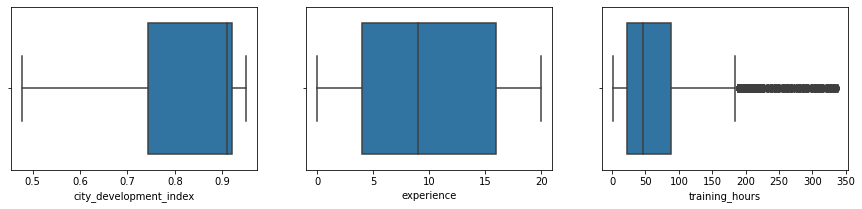

In [40]:
# Create a figure and axes
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

# Plot the first distplot on the first axes
sns.boxplot(x = new_df['city_development_index'],ax = ax[0])
sns.boxplot(x = new_df['experience'],ax = ax[1])
sns.boxplot(x = new_df['training_hours'],ax = ax[2])

# Show the plot
plt.show()

In [39]:
# Now let's see total number of outliers in city_development index
q1 = new_df['city_development_index'].quantile(0.25)
q3 = new_df['city_development_index'].quantile(0.75)

IQR = q3-q1
Lower_lmt_cdi = q1-(1.5*IQR)
Upper_lmt_cdi = q3 + (1.5*IQR)

new_df['city_development_index'] = np.where(
    new_df['city_development_index'] > Upper_lmt,
    Upper_lmt,
    np.where(
        new_df['city_development_index'] < Lower_lmt,
        Lower_lmt,
        new_df['city_development_index']
    )
)

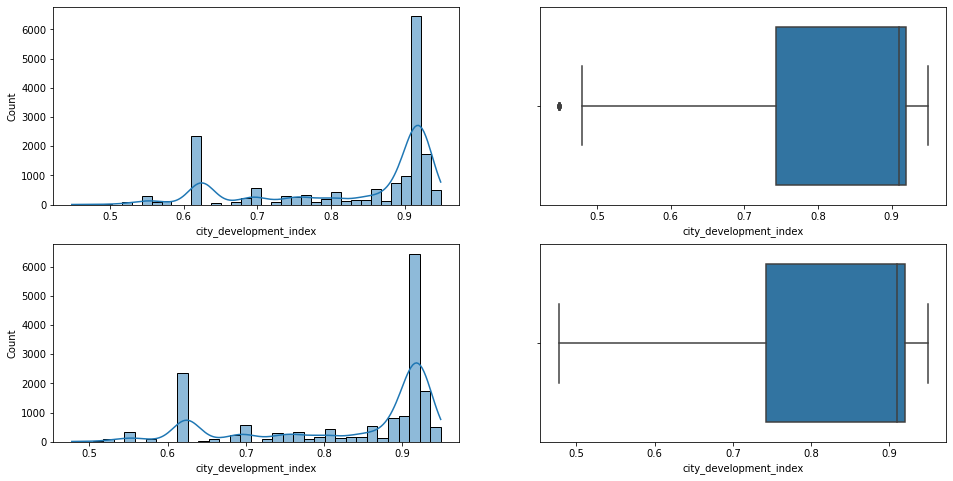

In [42]:
# Let's compare the distribution before and after capping the outliers 
plt.figure(figsize=(16,8))

# Before capping
plt.subplot(2,2,1)
sns.histplot(df['city_development_index'],kde=True)
plt.subplot(2,2,2)
sns.boxplot(x = df['city_development_index'])

# After capping
plt.subplot(2,2,3)
sns.histplot(new_df['city_development_index'],kde=True)
plt.subplot(2,2,4)
sns.boxplot(x = new_df['city_development_index'])

plt.show()

In [55]:
# Now let's see cap outliers in the training hours feature
q1 = new_df['training_hours'].quantile(0.25)
q3 = new_df['training_hours'].quantile(0.75)

IQR = q3-q1
Lower_lmt_th = q1-(1.5*IQR)
Upper_lmt_th = q3 + (1.5*IQR)

new_df['training_hours'] = np.where(
    new_df['training_hours'] > Upper_lmt,
    Upper_lmt,
    np.where(
        new_df['training_hours'] < Lower_lmt,
        Lower_lmt,
        new_df['training_hours']
    )
)

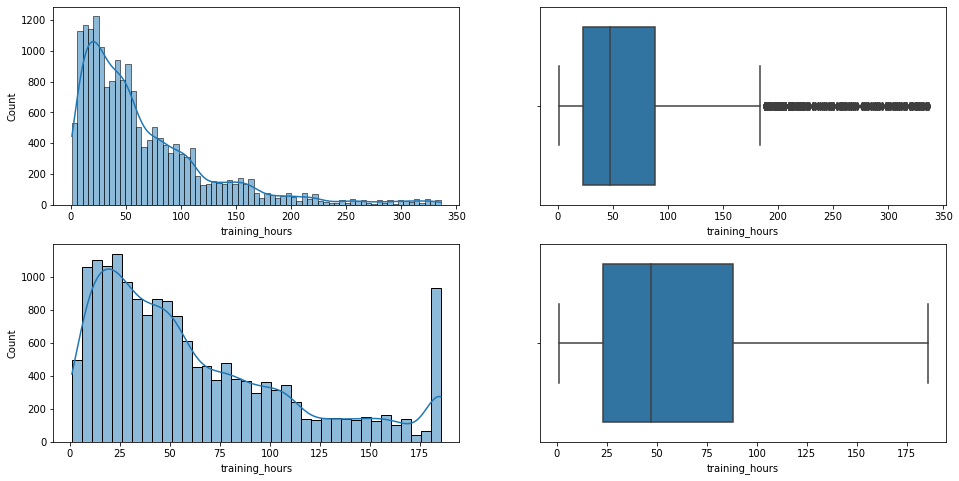

In [95]:
# Let's compare the distribution before and after capping the outliers 
plt.figure(figsize=(16,8))

# Before capping
plt.subplot(2,2,1)
sns.histplot(df['training_hours'],kde=True)
plt.subplot(2,2,2)
sns.boxplot(x = df['training_hours'])

# After capping
plt.subplot(2,2,3)
sns.histplot(new_df['training_hours'],kde=True)
plt.subplot(2,2,4)
sns.boxplot(x = new_df['training_hours'])

plt.show()

In [66]:
# Now some visualization or analysis purpose let us convert the encoded categorical data to categories
# map_re = {1.0:'Has relevent experience',0.0:'No relevent experience'}
# new_df['relevent_experience'] = new_df['relevent_experience'].map(map_re)

In [70]:
# map_eu = {2.0:'Full time course' ,1.0:'Part time course', 0.0:'no_enrollment'}
# new_df['enrolled_university'] = new_df['enrolled_university'].map(map_eu)

In [72]:
# map_el = {0.0:'Primary School',1.1: 'High School', 2.0:'Graduate',3.0:'Masters',4.0:'Phd'}
# new_df['education_level'] = new_df['education_level'].map(map_el)

In [80]:
# new_df['company_size'] = new_df['company_size'].astype(np.int32)
# map_cs = {0:'<10',1:'10/49',2:'50-99',3:'100-500',4:'500-999',5:'1000-4999',6:'5000-9999',7:'10000+'}
# new_df['company_size'] = new_df['company_size'].map(map_cs)